In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
%matplotlib inline
import time

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/font_manager.py:278: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [3]:
# choose best device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [4]:
# create data transforms. 
# Apart from the resize and normalization, 
# let us also do data augmentation
batch_size=100
mean = (0.5,0.5,0.5)
std = (0.5,0.5,0.5)
train_transforms = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.RandomAffine(0,shear=7,scale=(0.9,1.1)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1,0.1,0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])
val_transforms = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])
# Create the training and validation datasets
train_ds = datasets.CIFAR10(root='./cifar_data',download=True,
                           train=True,transform=train_transforms)
val_ds = datasets.CIFAR10(root='./cifar_data',download=True,
                         train=False,transform=val_transforms)
# Create data loaders
train_loader = DataLoader(train_ds,shuffle=True,batch_size=batch_size)
val_loader = DataLoader(val_ds,shuffle=False,batch_size=batch_size)
classes = ["airplane",'automobile','bird','cat','deer',
          'dog','frog','horse','ship','truck']

Files already downloaded and verified
Files already downloaded and verified


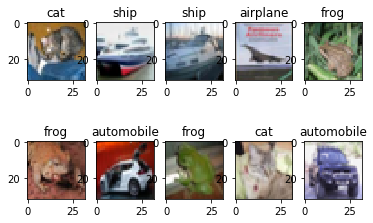

In [5]:
# View sample image
def image_decode(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1,2,0)
    image = image*np.array(std)+np.array(mean)
    image = image.clip(0,1)
    return image

def show_10_samples(samples,labels):
    fig,axes = plt.subplots(2,5)
    for row in range(2):
        for col in range(5):
            axis = axes[row,col]
            index = row*5+col
            axis.imshow(image_decode(samples[index]))
            axis.set_title(classes[labels[index].item()])
    plt.show()

temp_samples,temp_labels = next(iter(val_loader))
show_10_samples(temp_samples,temp_labels)

In [7]:
# (Conv+MaxPool)*3 with doubling of filters
# Define the network, loss and optimizer
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(3,64,3,1,1)
        self.c1a = nn.ReLU()
        self.s1 = nn.MaxPool2d((2,2),2)
        self.c2 = nn.Conv2d(64,128,3,1,1)
        self.c2a = nn.ReLU()  
        self.s2 = nn.MaxPool2d((2,2),2)
        self.c3 = nn.Conv2d(128,256,3,1,1)
        self.c3a = nn.ReLU()    
        self.s3 = nn.MaxPool2d((2,2),2)


        self.fc1 = nn.Linear(4*4*256,1024)
        self.fc1a = nn.ReLU()
        self.fc2 = nn.Linear(1024,10)
        self.fc2a = nn.Softmax(1)
        
        self.cnn_layers = [self.c1,self.c1a,self.s1,self.c2,self.c2a,self.s2,
                           self.c3,self.c3a,self.s3]
        self.fc_layers = [self.fc1,self.fc1a,self.fc2,self.fc2a]
        
    def forward(self,x):
        for layer in self.cnn_layers:
            x = layer(x)
        x = x.view(x.shape[0],-1)
        for layer in self.fc_layers:
            x = layer(x)
        return x

net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(),lr=0.001)

# Test net mathematics
with torch.no_grad():
    temp_samples = temp_samples.to(device)
    temp_output = net.forward(temp_samples)
    print(temp_output.shape)
        

torch.Size([100, 10])


In [8]:
print(net)

Net(
  (c1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c1a): ReLU()
  (s1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (c2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c2a): ReLU()
  (s2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (c3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c3a): ReLU()
  (s3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (fc1a): ReLU()
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
  (fc2a): Softmax()
)


In [9]:
# train the network
epochs = 30
train_accuracies=[]
val_accuracies=[]
train_losses = []
val_losses = []
for epoch in range(epochs):
    t1 = time.time() 
    total_loss=0
    total_correct=0
    for index,(samples,labels) in enumerate(train_loader):
        samples = samples.to(device)
        labels = labels.to(device)
        outputs = net.forward(samples)
        loss = criterion(outputs,labels)
        preds = torch.argmax(outputs,1)
        total_loss += loss
        total_correct += torch.sum(preds == labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#         if index % 50==49:
#             print('.',end='')
    with torch.no_grad():
        val_loss=0
        val_correct=0
        for samples,labels in val_loader:
            samples = samples.to(device)
            labels = labels.to(device)
            outputs = net.forward(samples)
            loss = criterion(outputs,labels)
            preds = torch.argmax(outputs,1)
            val_loss += loss
            val_correct += torch.sum(preds==labels)
        print('\nEpoch:',epoch+1,
             'Training loss:',round(total_loss.item()*batch_size/len(train_ds),3),
             'Training accuracy:',round(total_correct.item()/len(train_ds),3),
             'Val loss:',round(val_loss.item()*batch_size/len(val_ds),3),
             'Val accuracy:',round(val_correct.item()/len(val_ds),3),
             'Time taken:',round(time.time()-t1))
        train_accuracies.append(round(total_correct.item()/len(train_ds),3))
        val_accuracies.append(round(val_correct.item()/len(val_ds),3))
        train_losses.append(round(total_loss.item()*batch_size/len(train_ds),3))
        val_losses.append(round(val_loss.item()*batch_size/len(val_ds),3))

print("Training accuracies:",train_accuracies)
print("Validation accuracies:",val_accuracies)


Epoch: 1 Training loss: 2.087 Training accuracy: 0.365 Val loss: 1.985 Val accuracy: 0.469 Time taken: 33

Epoch: 2 Training loss: 1.984 Training accuracy: 0.471 Val loss: 1.956 Val accuracy: 0.5 Time taken: 32

Epoch: 3 Training loss: 1.945 Training accuracy: 0.51 Val loss: 1.922 Val accuracy: 0.535 Time taken: 32

Epoch: 4 Training loss: 1.905 Training accuracy: 0.553 Val loss: 1.874 Val accuracy: 0.584 Time taken: 32

Epoch: 5 Training loss: 1.894 Training accuracy: 0.563 Val loss: 1.861 Val accuracy: 0.596 Time taken: 31

Epoch: 6 Training loss: 1.868 Training accuracy: 0.589 Val loss: 1.848 Val accuracy: 0.61 Time taken: 32

Epoch: 7 Training loss: 1.863 Training accuracy: 0.596 Val loss: 1.83 Val accuracy: 0.628 Time taken: 32

Epoch: 8 Training loss: 1.848 Training accuracy: 0.611 Val loss: 1.828 Val accuracy: 0.631 Time taken: 32

Epoch: 9 Training loss: 1.842 Training accuracy: 0.616 Val loss: 1.839 Val accuracy: 0.619 Time taken: 32

Epoch: 10 Training loss: 1.831 Training a

In [11]:
# Network: (Conv+Conv+MaxPool)+(Conv+MaxPool)+(Conv+MaxPool)
# Define the network, loss and optimizer
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(3,64,3,1,1)
        self.c1a = nn.ReLU()
        self.c2 = nn.Conv2d(64,64,3,1,1)
        self.c2a = nn.ReLU()        
        self.s1 = nn.MaxPool2d((2,2),2)
        self.c3 = nn.Conv2d(64,64,3,1,1)
        self.c3a = nn.ReLU()  
        self.s2 = nn.MaxPool2d((2,2),2)
        self.c4 = nn.Conv2d(64,64,3,1,1)
        self.c4a = nn.ReLU()    
        self.s3 = nn.MaxPool2d((2,2),2)


        self.fc1 = nn.Linear(4*4*64,1024)
        self.fc1a = nn.ReLU()
        self.fc2 = nn.Linear(1024,10)
        self.fc2a = nn.Softmax(1)
        
        self.cnn_layers = [self.c1,self.c1a,self.c2,self.c2a,self.s1,self.c3,self.c3a,self.s2,
                           self.c4,self.c4a,self.s3]
        self.fc_layers = [self.fc1,self.fc1a,self.fc2,self.fc2a]
        
    def forward(self,x):
        for layer in self.cnn_layers:
            x = layer(x)
        x = x.view(x.shape[0],-1)
        for layer in self.fc_layers:
            x = layer(x)
        return x

net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(),lr=0.001)

# Test net mathematics
with torch.no_grad():
    temp_samples = temp_samples.to(device)
    temp_output = net.forward(temp_samples)
    print(temp_output.shape)
print(net)
# train the network
epochs = 30
train_accuracies=[]
val_accuracies=[]
train_losses = []
val_losses = []
for epoch in range(epochs):
    t1 = time.time() 
    total_loss=0
    total_correct=0
    for index,(samples,labels) in enumerate(train_loader):
        samples = samples.to(device)
        labels = labels.to(device)
        outputs = net.forward(samples)
        loss = criterion(outputs,labels)
        preds = torch.argmax(outputs,1)
        total_loss += loss
        total_correct += torch.sum(preds == labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#         if index % 50==49:
#             print('.',end='')
    with torch.no_grad():
        val_loss=0
        val_correct=0
        for samples,labels in val_loader:
            samples = samples.to(device)
            labels = labels.to(device)
            outputs = net.forward(samples)
            loss = criterion(outputs,labels)
            preds = torch.argmax(outputs,1)
            val_loss += loss
            val_correct += torch.sum(preds==labels)
        print('\nEpoch:',epoch+1,
             'Training loss:',round(total_loss.item()*batch_size/len(train_ds),3),
             'Training accuracy:',round(total_correct.item()/len(train_ds),3),
             'Val loss:',round(val_loss.item()*batch_size/len(val_ds),3),
             'Val accuracy:',round(val_correct.item()/len(val_ds),3),
             'Time taken:',round(time.time()-t1))
        train_accuracies.append(round(total_correct.item()/len(train_ds),3))
        val_accuracies.append(round(val_correct.item()/len(val_ds),3))
        train_losses.append(round(total_loss.item()*batch_size/len(train_ds),3))
        val_losses.append(round(val_loss.item()*batch_size/len(val_ds),3))
print("Training losses:",train_losses)
print("Training accuracies:",train_accuracies)
print("Validation losses:",val_losses)
print("Validation accuracies:",val_accuracies)

torch.Size([100, 10])
Net(
  (c1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c1a): ReLU()
  (c2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c2a): ReLU()
  (s1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (c3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c3a): ReLU()
  (s2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (c4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c4a): ReLU()
  (s3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (fc1a): ReLU()
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
  (fc2a): Softmax()
)

Epoch: 1 Training loss: 2.138 Training accuracy: 0.314 Val loss: 2.064 Val accuracy: 0.388 Time taken: 31

Epoch: 2 Training loss: 2.032 Training accuracy: 0.423 Val loss: 2.004 Val ac

In [14]:
# Network: (Conv+MaxPool)+(Conv+Conv+MaxPool)+(Conv+MaxPool)
# Define the network, loss and optimizer
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(3,64,3,1,1)
        self.c1a = nn.ReLU()
        self.s1 = nn.MaxPool2d((2,2),2)
        self.c2 = nn.Conv2d(64,64,3,1,1)
        self.c2a = nn.ReLU()        
        self.c3 = nn.Conv2d(64,64,3,1,1)
        self.c3a = nn.ReLU()  
        self.s2 = nn.MaxPool2d((2,2),2)
        self.c4 = nn.Conv2d(64,64,3,1,1)
        self.c4a = nn.ReLU()    
        self.s3 = nn.MaxPool2d((2,2),2)


        self.fc1 = nn.Linear(4*4*64,1024)
        self.fc1a = nn.ReLU()
        self.fc2 = nn.Linear(1024,10)
        self.fc2a = nn.Softmax(1)
        
        self.cnn_layers = [self.c1,self.c1a,self.s1,self.c2,self.c2a,self.c3,self.c3a,self.s2,
                           self.c4,self.c4a,self.s3]
        self.fc_layers = [self.fc1,self.fc1a,self.fc2,self.fc2a]
        
    def forward(self,x):
        for layer in self.cnn_layers:
            x = layer(x)
        x = x.view(x.shape[0],-1)
        for layer in self.fc_layers:
            x = layer(x)
        return x

net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(),lr=0.001)

# Test net mathematics
with torch.no_grad():
    temp_samples = temp_samples.to(device)
    temp_output = net.forward(temp_samples)
    print(temp_output.shape)
print(net)
# train the network
epochs = 30
train_accuracies=[]
val_accuracies=[]
train_losses = []
val_losses = []
for epoch in range(epochs):
    t1 = time.time() 
    total_loss=0
    total_correct=0
    for index,(samples,labels) in enumerate(train_loader):
        samples = samples.to(device)
        labels = labels.to(device)
        outputs = net.forward(samples)
        loss = criterion(outputs,labels)
        preds = torch.argmax(outputs,1)
        total_loss += loss
        total_correct += torch.sum(preds == labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#         if index % 50==49:
#             print('.',end='')
    with torch.no_grad():
        val_loss=0
        val_correct=0
        for samples,labels in val_loader:
            samples = samples.to(device)
            labels = labels.to(device)
            outputs = net.forward(samples)
            loss = criterion(outputs,labels)
            preds = torch.argmax(outputs,1)
            val_loss += loss
            val_correct += torch.sum(preds==labels)
        print('\nEpoch:',epoch+1,
             'Training loss:',round(total_loss.item()*batch_size/len(train_ds),3),
             'Training accuracy:',round(total_correct.item()/len(train_ds),3),
             'Val loss:',round(val_loss.item()*batch_size/len(val_ds),3),
             'Val accuracy:',round(val_correct.item()/len(val_ds),3),
             'Time taken:',round(time.time()-t1))
        train_accuracies.append(round(total_correct.item()/len(train_ds),3))
        val_accuracies.append(round(val_correct.item()/len(val_ds),3))
        train_losses.append(round(total_loss.item()*batch_size/len(train_ds),3))
        val_losses.append(round(val_loss.item()*batch_size/len(val_ds),3))
print("Training losses:",train_losses)
print("Training accuracies:",train_accuracies)
print("Validation losses:",val_losses)
print("Validation accuracies:",val_accuracies)

torch.Size([100, 10])
Net(
  (c1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c1a): ReLU()
  (s1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (c2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c2a): ReLU()
  (c3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c3a): ReLU()
  (s2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (c4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c4a): ReLU()
  (s3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (fc1a): ReLU()
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
  (fc2a): Softmax()
)

Epoch: 1 Training loss: 2.178 Training accuracy: 0.272 Val loss: 2.09 Val accuracy: 0.365 Time taken: 31

Epoch: 2 Training loss: 2.045 Training accuracy: 0.409 Val loss: 1.998 Val acc

In [13]:
# Network: (Conv+MaxPool)+(Conv+MaxPool)+(Conv+Conv+MaxPool)
# Define the network, loss and optimizer
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(3,64,3,1,1)
        self.c1a = nn.ReLU()
        self.s1 = nn.MaxPool2d((2,2),2)
        self.c2 = nn.Conv2d(64,64,3,1,1)
        self.c2a = nn.ReLU()        
        self.s2 = nn.MaxPool2d((2,2),2)
        self.c3 = nn.Conv2d(64,64,3,1,1)
        self.c3a = nn.ReLU()  
        self.c4 = nn.Conv2d(64,64,3,1,1)
        self.c4a = nn.ReLU()    
        self.s3 = nn.MaxPool2d((2,2),2)


        self.fc1 = nn.Linear(4*4*64,1024)
        self.fc1a = nn.ReLU()
        self.fc2 = nn.Linear(1024,10)
        self.fc2a = nn.Softmax(1)
        
        self.cnn_layers = [self.c1,self.c1a,self.s1,self.c2,self.c2a,self.s2,self.c3,self.c3a,
                           self.c4,self.c4a,self.s3]
        self.fc_layers = [self.fc1,self.fc1a,self.fc2,self.fc2a]
        
    def forward(self,x):
        for layer in self.cnn_layers:
            x = layer(x)
        x = x.view(x.shape[0],-1)
        for layer in self.fc_layers:
            x = layer(x)
        return x

net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(),lr=0.001)

# Test net mathematics
with torch.no_grad():
    temp_samples = temp_samples.to(device)
    temp_output = net.forward(temp_samples)
    print(temp_output.shape)
print(net)
# train the network
epochs = 30
train_accuracies=[]
val_accuracies=[]
train_losses = []
val_losses = []
for epoch in range(epochs):
    t1 = time.time() 
    total_loss=0
    total_correct=0
    for index,(samples,labels) in enumerate(train_loader):
        samples = samples.to(device)
        labels = labels.to(device)
        outputs = net.forward(samples)
        loss = criterion(outputs,labels)
        preds = torch.argmax(outputs,1)
        total_loss += loss
        total_correct += torch.sum(preds == labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#         if index % 50==49:
#             print('.',end='')
    with torch.no_grad():
        val_loss=0
        val_correct=0
        for samples,labels in val_loader:
            samples = samples.to(device)
            labels = labels.to(device)
            outputs = net.forward(samples)
            loss = criterion(outputs,labels)
            preds = torch.argmax(outputs,1)
            val_loss += loss
            val_correct += torch.sum(preds==labels)
        print('\nEpoch:',epoch+1,
             'Training loss:',round(total_loss.item()*batch_size/len(train_ds),3),
             'Training accuracy:',round(total_correct.item()/len(train_ds),3),
             'Val loss:',round(val_loss.item()*batch_size/len(val_ds),3),
             'Val accuracy:',round(val_correct.item()/len(val_ds),3),
             'Time taken:',round(time.time()-t1))
        train_accuracies.append(round(total_correct.item()/len(train_ds),3))
        val_accuracies.append(round(val_correct.item()/len(val_ds),3))
        train_losses.append(round(total_loss.item()*batch_size/len(train_ds),3))
        val_losses.append(round(val_loss.item()*batch_size/len(val_ds),3))
print("Training losses:",train_losses)
print("Training accuracies:",train_accuracies)
print("Validation losses:",val_losses)
print("Validation accuracies:",val_accuracies)

torch.Size([100, 10])
Net(
  (c1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c1a): ReLU()
  (s1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (c2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c2a): ReLU()
  (s2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (c3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c3a): ReLU()
  (c4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c4a): ReLU()
  (s3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (fc1a): ReLU()
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
  (fc2a): Softmax()
)

Epoch: 1 Training loss: 2.144 Training accuracy: 0.305 Val loss: 2.045 Val accuracy: 0.41 Time taken: 31

Epoch: 2 Training loss: 2.034 Training accuracy: 0.422 Val loss: 1.995 Val acc

In [15]:
# Network: (Conv+Conv*+MaxPool)+(Conv+MaxPool)+(Conv+MaxPool)
# Define the network, loss and optimizer
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(3,64,3,1,1)
        self.c1a = nn.ReLU()
        self.c2 = nn.Conv2d(64,128,3,1,1)
        self.c2a = nn.ReLU()        
        self.s1 = nn.MaxPool2d((2,2),2)
        self.c3 = nn.Conv2d(128,128,3,1,1)
        self.c3a = nn.ReLU()  
        self.s2 = nn.MaxPool2d((2,2),2)
        self.c4 = nn.Conv2d(128,128,3,1,1)
        self.c4a = nn.ReLU()    
        self.s3 = nn.MaxPool2d((2,2),2)


        self.fc1 = nn.Linear(4*4*128,1024)
        self.fc1a = nn.ReLU()
        self.fc2 = nn.Linear(1024,10)
        self.fc2a = nn.Softmax(1)
        
        self.cnn_layers = [self.c1,self.c1a,self.c2,self.c2a,self.s1,self.c3,self.c3a,self.s2,
                           self.c4,self.c4a,self.s3]
        self.fc_layers = [self.fc1,self.fc1a,self.fc2,self.fc2a]
        
    def forward(self,x):
        for layer in self.cnn_layers:
            x = layer(x)
        x = x.view(x.shape[0],-1)
        for layer in self.fc_layers:
            x = layer(x)
        return x

net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(),lr=0.001)

# Test net mathematics
with torch.no_grad():
    temp_samples = temp_samples.to(device)
    temp_output = net.forward(temp_samples)
    print(temp_output.shape)
print(net)
# train the network
epochs = 30
train_accuracies=[]
val_accuracies=[]
train_losses = []
val_losses = []
for epoch in range(epochs):
    t1 = time.time() 
    total_loss=0
    total_correct=0
    for index,(samples,labels) in enumerate(train_loader):
        samples = samples.to(device)
        labels = labels.to(device)
        outputs = net.forward(samples)
        loss = criterion(outputs,labels)
        preds = torch.argmax(outputs,1)
        total_loss += loss
        total_correct += torch.sum(preds == labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#         if index % 50==49:
#             print('.',end='')
    with torch.no_grad():
        val_loss=0
        val_correct=0
        for samples,labels in val_loader:
            samples = samples.to(device)
            labels = labels.to(device)
            outputs = net.forward(samples)
            loss = criterion(outputs,labels)
            preds = torch.argmax(outputs,1)
            val_loss += loss
            val_correct += torch.sum(preds==labels)
        print('\nEpoch:',epoch+1,
             'Training loss:',round(total_loss.item()*batch_size/len(train_ds),3),
             'Training accuracy:',round(total_correct.item()/len(train_ds),3),
             'Val loss:',round(val_loss.item()*batch_size/len(val_ds),3),
             'Val accuracy:',round(val_correct.item()/len(val_ds),3),
             'Time taken:',round(time.time()-t1))
        train_accuracies.append(round(total_correct.item()/len(train_ds),3))
        val_accuracies.append(round(val_correct.item()/len(val_ds),3))
        train_losses.append(round(total_loss.item()*batch_size/len(train_ds),3))
        val_losses.append(round(val_loss.item()*batch_size/len(val_ds),3))
print("Training losses:",train_losses)
print("Training accuracies:",train_accuracies)
print("Validation losses:",val_losses)
print("Validation accuracies:",val_accuracies)

torch.Size([100, 10])
Net(
  (c1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c1a): ReLU()
  (c2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c2a): ReLU()
  (s1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (c3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c3a): ReLU()
  (s2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (c4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c4a): ReLU()
  (s3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc1a): ReLU()
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
  (fc2a): Softmax()
)

Epoch: 1 Training loss: 2.166 Training accuracy: 0.286 Val loss: 2.069 Val accuracy: 0.386 Time taken: 58

Epoch: 2 Training loss: 2.053 Training accuracy: 0.402 Val loss: 2.014 V

In [16]:
# Network: (Conv+MaxPool)+(Conv+Conv*+MaxPool)+(Conv+MaxPool)
# Define the network, loss and optimizer
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(3,64,3,1,1)
        self.c1a = nn.ReLU()
        self.s1 = nn.MaxPool2d((2,2),2)
        self.c2 = nn.Conv2d(64,64,3,1,1)
        self.c2a = nn.ReLU()        
        self.c3 = nn.Conv2d(64,128,3,1,1)
        self.c3a = nn.ReLU()  
        self.s2 = nn.MaxPool2d((2,2),2)
        self.c4 = nn.Conv2d(128,128,3,1,1)
        self.c4a = nn.ReLU()    
        self.s3 = nn.MaxPool2d((2,2),2)


        self.fc1 = nn.Linear(4*4*128,1024)
        self.fc1a = nn.ReLU()
        self.fc2 = nn.Linear(1024,10)
        self.fc2a = nn.Softmax(1)
        
        self.cnn_layers = [self.c1,self.c1a,self.s1,self.c2,self.c2a,self.c3,self.c3a,self.s2,
                           self.c4,self.c4a,self.s3]
        self.fc_layers = [self.fc1,self.fc1a,self.fc2,self.fc2a]
        
    def forward(self,x):
        for layer in self.cnn_layers:
            x = layer(x)
        x = x.view(x.shape[0],-1)
        for layer in self.fc_layers:
            x = layer(x)
        return x

net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(),lr=0.001)

# Test net mathematics
with torch.no_grad():
    temp_samples = temp_samples.to(device)
    temp_output = net.forward(temp_samples)
    print(temp_output.shape)
print(net)
# train the network
epochs = 30
train_accuracies=[]
val_accuracies=[]
train_losses = []
val_losses = []
for epoch in range(epochs):
    t1 = time.time() 
    total_loss=0
    total_correct=0
    for index,(samples,labels) in enumerate(train_loader):
        samples = samples.to(device)
        labels = labels.to(device)
        outputs = net.forward(samples)
        loss = criterion(outputs,labels)
        preds = torch.argmax(outputs,1)
        total_loss += loss
        total_correct += torch.sum(preds == labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#         if index % 50==49:
#             print('.',end='')
    with torch.no_grad():
        val_loss=0
        val_correct=0
        for samples,labels in val_loader:
            samples = samples.to(device)
            labels = labels.to(device)
            outputs = net.forward(samples)
            loss = criterion(outputs,labels)
            preds = torch.argmax(outputs,1)
            val_loss += loss
            val_correct += torch.sum(preds==labels)
        print('\nEpoch:',epoch+1,
             'Training loss:',round(total_loss.item()*batch_size/len(train_ds),3),
             'Training accuracy:',round(total_correct.item()/len(train_ds),3),
             'Val loss:',round(val_loss.item()*batch_size/len(val_ds),3),
             'Val accuracy:',round(val_correct.item()/len(val_ds),3),
             'Time taken:',round(time.time()-t1))
        train_accuracies.append(round(total_correct.item()/len(train_ds),3))
        val_accuracies.append(round(val_correct.item()/len(val_ds),3))
        train_losses.append(round(total_loss.item()*batch_size/len(train_ds),3))
        val_losses.append(round(val_loss.item()*batch_size/len(val_ds),3))
print("Training losses:",train_losses)
print("Training accuracies:",train_accuracies)
print("Validation losses:",val_losses)
print("Validation accuracies:",val_accuracies)

torch.Size([100, 10])
Net(
  (c1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c1a): ReLU()
  (s1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (c2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c2a): ReLU()
  (c3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c3a): ReLU()
  (s2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (c4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c4a): ReLU()
  (s3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc1a): ReLU()
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
  (fc2a): Softmax()
)

Epoch: 1 Training loss: 2.177 Training accuracy: 0.276 Val loss: 2.088 Val accuracy: 0.366 Time taken: 31

Epoch: 2 Training loss: 2.07 Training accuracy: 0.385 Val loss: 2.001 Val 

In [17]:
# Network: (Conv+MaxPool)+(Conv+MaxPool)+(Conv+Conv*+MaxPool)
# Define the network, loss and optimizer
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(3,64,3,1,1)
        self.c1a = nn.ReLU()
        self.s1 = nn.MaxPool2d((2,2),2)
        self.c2 = nn.Conv2d(64,64,3,1,1)
        self.c2a = nn.ReLU()        
        self.s2 = nn.MaxPool2d((2,2),2)
        self.c3 = nn.Conv2d(64,64,3,1,1)
        self.c3a = nn.ReLU()  
        self.c4 = nn.Conv2d(64,128,3,1,1)
        self.c4a = nn.ReLU()    
        self.s3 = nn.MaxPool2d((2,2),2)


        self.fc1 = nn.Linear(4*4*128,1024)
        self.fc1a = nn.ReLU()
        self.fc2 = nn.Linear(1024,10)
        self.fc2a = nn.Softmax(1)
        
        self.cnn_layers = [self.c1,self.c1a,self.s1,self.c2,self.c2a,self.s2,self.c3,self.c3a,
                           self.c4,self.c4a,self.s3]
        self.fc_layers = [self.fc1,self.fc1a,self.fc2,self.fc2a]
        
    def forward(self,x):
        for layer in self.cnn_layers:
            x = layer(x)
        x = x.view(x.shape[0],-1)
        for layer in self.fc_layers:
            x = layer(x)
        return x

net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(),lr=0.001)

# Test net mathematics
with torch.no_grad():
    temp_samples = temp_samples.to(device)
    temp_output = net.forward(temp_samples)
    print(temp_output.shape)
print(net)
# train the network
epochs = 30
train_accuracies=[]
val_accuracies=[]
train_losses = []
val_losses = []
for epoch in range(epochs):
    t1 = time.time() 
    total_loss=0
    total_correct=0
    for index,(samples,labels) in enumerate(train_loader):
        samples = samples.to(device)
        labels = labels.to(device)
        outputs = net.forward(samples)
        loss = criterion(outputs,labels)
        preds = torch.argmax(outputs,1)
        total_loss += loss
        total_correct += torch.sum(preds == labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#         if index % 50==49:
#             print('.',end='')
    with torch.no_grad():
        val_loss=0
        val_correct=0
        for samples,labels in val_loader:
            samples = samples.to(device)
            labels = labels.to(device)
            outputs = net.forward(samples)
            loss = criterion(outputs,labels)
            preds = torch.argmax(outputs,1)
            val_loss += loss
            val_correct += torch.sum(preds==labels)
        print('\nEpoch:',epoch+1,
             'Training loss:',round(total_loss.item()*batch_size/len(train_ds),3),
             'Training accuracy:',round(total_correct.item()/len(train_ds),3),
             'Val loss:',round(val_loss.item()*batch_size/len(val_ds),3),
             'Val accuracy:',round(val_correct.item()/len(val_ds),3),
             'Time taken:',round(time.time()-t1))
        train_accuracies.append(round(total_correct.item()/len(train_ds),3))
        val_accuracies.append(round(val_correct.item()/len(val_ds),3))
        train_losses.append(round(total_loss.item()*batch_size/len(train_ds),3))
        val_losses.append(round(val_loss.item()*batch_size/len(val_ds),3))
print("Training losses:",train_losses)
print("Training accuracies:",train_accuracies)
print("Validation losses:",val_losses)
print("Validation accuracies:",val_accuracies)

torch.Size([100, 10])
Net(
  (c1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c1a): ReLU()
  (s1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (c2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c2a): ReLU()
  (s2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (c3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c3a): ReLU()
  (c4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c4a): ReLU()
  (s3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc1a): ReLU()
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
  (fc2a): Softmax()
)

Epoch: 1 Training loss: 2.129 Training accuracy: 0.321 Val loss: 2.058 Val accuracy: 0.395 Time taken: 31

Epoch: 2 Training loss: 2.032 Training accuracy: 0.423 Val loss: 1.987 Val a

In [18]:
# Network: Conv+Pooling+Conv*+Pooling
# Define the network, loss and optimizer
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(3,64,3,1,1)
        self.c1a = nn.ReLU()
        self.s1 = nn.MaxPool2d((2,2),2)
        self.c2 = nn.Conv2d(64,128,3,1,1)
        self.c2a = nn.ReLU()        
        self.s2 = nn.MaxPool2d((2,2),2)


        self.fc1 = nn.Linear(8*8*128,1024)
        self.fc1a = nn.ReLU()
        self.fc2 = nn.Linear(1024,10)
        self.fc2a = nn.Softmax(1)
        
        self.cnn_layers = [self.c1,self.c1a,self.s1,self.c2,self.c2a,self.s2]
        self.fc_layers = [self.fc1,self.fc1a,self.fc2,self.fc2a]
        
    def forward(self,x):
        for layer in self.cnn_layers:
            x = layer(x)
        x = x.view(x.shape[0],-1)
        for layer in self.fc_layers:
            x = layer(x)
        return x

net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(),lr=0.001)

# Test net mathematics
with torch.no_grad():
    temp_samples = temp_samples.to(device)
    temp_output = net.forward(temp_samples)
    print(temp_output.shape)
print(net)
# train the network
epochs = 30
train_accuracies=[]
val_accuracies=[]
train_losses = []
val_losses = []
for epoch in range(epochs):
    t1 = time.time() 
    total_loss=0
    total_correct=0
    for index,(samples,labels) in enumerate(train_loader):
        samples = samples.to(device)
        labels = labels.to(device)
        outputs = net.forward(samples)
        loss = criterion(outputs,labels)
        preds = torch.argmax(outputs,1)
        total_loss += loss
        total_correct += torch.sum(preds == labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#         if index % 50==49:
#             print('.',end='')
    with torch.no_grad():
        val_loss=0
        val_correct=0
        for samples,labels in val_loader:
            samples = samples.to(device)
            labels = labels.to(device)
            outputs = net.forward(samples)
            loss = criterion(outputs,labels)
            preds = torch.argmax(outputs,1)
            val_loss += loss
            val_correct += torch.sum(preds==labels)
        print('\nEpoch:',epoch+1,
             'Training loss:',round(total_loss.item()*batch_size/len(train_ds),3),
             'Training accuracy:',round(total_correct.item()/len(train_ds),3),
             'Val loss:',round(val_loss.item()*batch_size/len(val_ds),3),
             'Val accuracy:',round(val_correct.item()/len(val_ds),3),
             'Time taken:',round(time.time()-t1))
        train_accuracies.append(round(total_correct.item()/len(train_ds),3))
        val_accuracies.append(round(val_correct.item()/len(val_ds),3))
        train_losses.append(round(total_loss.item()*batch_size/len(train_ds),3))
        val_losses.append(round(val_loss.item()*batch_size/len(val_ds),3))
print("Training losses:",train_losses)
print("Training accuracies:",train_accuracies)
print("Validation losses:",val_losses)
print("Validation accuracies:",val_accuracies)

torch.Size([100, 10])
Net(
  (c1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c1a): ReLU()
  (s1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (c2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c2a): ReLU()
  (s2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=1024, bias=True)
  (fc1a): ReLU()
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
  (fc2a): Softmax()
)

Epoch: 1 Training loss: 2.075 Training accuracy: 0.379 Val loss: 1.967 Val accuracy: 0.492 Time taken: 31

Epoch: 2 Training loss: 1.973 Training accuracy: 0.484 Val loss: 1.918 Val accuracy: 0.539 Time taken: 30

Epoch: 3 Training loss: 1.929 Training accuracy: 0.528 Val loss: 1.905 Val accuracy: 0.553 Time taken: 30

Epoch: 4 Training loss: 1.893 Training accuracy: 0.564 Val loss: 1.868 Val accuracy: 0.59 Time taken: 30

Epoch: 5 Training loss: 

In [20]:
# Network: LeNet
# Define the network, loss and optimizer
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(3,6,5,1,0)
        self.c1a = nn.Tanh()
        self.s2 = nn.AvgPool2d((2,2),2)
        self.c3 = nn.Conv2d(6,16,5,1,0)
        self.c3a = nn.Tanh()
        self.s4 = nn.AvgPool2d((2,2),2)
        self.c5 = nn.Conv2d(16,120,5,1,0)
        self.c5a = nn.Tanh()

        self.fc1 = nn.Linear(120,84)
        self.fc1a = nn.Tanh()
        self.fc2 = nn.Linear(84,10)
        self.fc2a = nn.Softmax(1)
        
        self.cnn_layers = [self.c1,self.c1a,self.s2,self.c3,self.c3a,self.s4,self.c5,self.c5a]
        self.fc_layers = [self.fc1,self.fc1a,self.fc2,self.fc2a]
        
    def forward(self,x):
        for layer in self.cnn_layers:
            x = layer(x)
        x = x.view(x.shape[0],-1)
        for layer in self.fc_layers:
            x = layer(x)
        return x

net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(),lr=0.001)

# Test net mathematics
with torch.no_grad():
    temp_samples = temp_samples.to(device)
    temp_output = net.forward(temp_samples)
    print(temp_output.shape)
print(net)
# train the network
epochs = 30
train_accuracies=[]
val_accuracies=[]
train_losses = []
val_losses = []
for epoch in range(epochs):
    t1 = time.time() 
    total_loss=0
    total_correct=0
    for index,(samples,labels) in enumerate(train_loader):
        samples = samples.to(device)
        labels = labels.to(device)
        outputs = net.forward(samples)
        loss = criterion(outputs,labels)
        preds = torch.argmax(outputs,1)
        total_loss += loss
        total_correct += torch.sum(preds == labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#         if index % 50==49:
#             print('.',end='')
    with torch.no_grad():
        val_loss=0
        val_correct=0
        for samples,labels in val_loader:
            samples = samples.to(device)
            labels = labels.to(device)
            outputs = net.forward(samples)
            loss = criterion(outputs,labels)
            preds = torch.argmax(outputs,1)
            val_loss += loss
            val_correct += torch.sum(preds==labels)
        print('\nEpoch:',epoch+1,
             'Training loss:',round(total_loss.item()*batch_size/len(train_ds),3),
             'Training accuracy:',round(total_correct.item()/len(train_ds),3),
             'Val loss:',round(val_loss.item()*batch_size/len(val_ds),3),
             'Val accuracy:',round(val_correct.item()/len(val_ds),3),
             'Time taken:',round(time.time()-t1))
        train_accuracies.append(round(total_correct.item()/len(train_ds),3))
        val_accuracies.append(round(val_correct.item()/len(val_ds),3))
        train_losses.append(round(total_loss.item()*batch_size/len(train_ds),3))
        val_losses.append(round(val_loss.item()*batch_size/len(val_ds),3))
print("Training losses:",train_losses)
print("Training accuracies:",train_accuracies)
print("Validation losses:",val_losses)
print("Validation accuracies:",val_accuracies)

torch.Size([100, 10])
Net(
  (c1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (c1a): Tanh()
  (s2): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (c3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (c3a): Tanh()
  (s4): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (c5): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (c5a): Tanh()
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc1a): Tanh()
  (fc2): Linear(in_features=84, out_features=10, bias=True)
  (fc2a): Softmax()
)

Epoch: 1 Training loss: 2.144 Training accuracy: 0.313 Val loss: 2.094 Val accuracy: 0.362 Time taken: 30

Epoch: 2 Training loss: 2.075 Training accuracy: 0.383 Val loss: 2.042 Val accuracy: 0.417 Time taken: 30

Epoch: 3 Training loss: 2.042 Training accuracy: 0.417 Val loss: 2.018 Val accuracy: 0.44 Time taken: 30

Epoch: 4 Training loss: 2.021 Training accuracy: 0.439 Val loss: 2.005 Val accuracy: 0.454 Time taken: 30

Epoch: 5 Training loss: 2.004 Training accuracy

In [21]:
# Network: Alexnet-like
# Define the network, loss and optimizer
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(3,16,5,2,0)
        self.c1a = nn.ReLU()
        self.s1 = nn.MaxPool2d((2,2),2)
        self.n1 = nn.BatchNorm2d(16)
        self.c2 = nn.Conv2d(16,32,3,1,0)
        self.c2a = nn.ReLU()
        self.s2 = nn.MaxPool2d((2,2),2)
        self.n2 = nn.BatchNorm2d(32)

        self.fc1 = nn.Linear(128,128)
        self.fc1a = nn.ReLU()
        self.fc2 = nn.Linear(128,10)
        self.fc2a = nn.Softmax(1)
        
        self.cnn_layers = [self.c1,self.c1a,self.s1,self.n1,self.c2,self.c2a,self.s2,self.n2]
        self.fc_layers = [self.fc1,self.fc1a,self.fc2,self.fc2a]
        
    def forward(self,x):
        for layer in self.cnn_layers:
            x = layer(x)
        x = x.view(x.shape[0],-1)
        for layer in self.fc_layers:
            x = layer(x)
        return x

net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(),lr=0.001)

# Test net mathematics
with torch.no_grad():
    temp_samples = temp_samples.to(device)
    temp_output = net.forward(temp_samples)
    print(temp_output.shape)
print(net)
# train the network
epochs = 30
train_accuracies=[]
val_accuracies=[]
train_losses = []
val_losses = []
for epoch in range(epochs):
    t1 = time.time() 
    total_loss=0
    total_correct=0
    for index,(samples,labels) in enumerate(train_loader):
        samples = samples.to(device)
        labels = labels.to(device)
        outputs = net.forward(samples)
        loss = criterion(outputs,labels)
        preds = torch.argmax(outputs,1)
        total_loss += loss
        total_correct += torch.sum(preds == labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#         if index % 50==49:
#             print('.',end='')
    with torch.no_grad():
        val_loss=0
        val_correct=0
        for samples,labels in val_loader:
            samples = samples.to(device)
            labels = labels.to(device)
            outputs = net.forward(samples)
            loss = criterion(outputs,labels)
            preds = torch.argmax(outputs,1)
            val_loss += loss
            val_correct += torch.sum(preds==labels)
        print('\nEpoch:',epoch+1,
             'Training loss:',round(total_loss.item()*batch_size/len(train_ds),3),
             'Training accuracy:',round(total_correct.item()/len(train_ds),3),
             'Val loss:',round(val_loss.item()*batch_size/len(val_ds),3),
             'Val accuracy:',round(val_correct.item()/len(val_ds),3),
             'Time taken:',round(time.time()-t1))
        train_accuracies.append(round(total_correct.item()/len(train_ds),3))
        val_accuracies.append(round(val_correct.item()/len(val_ds),3))
        train_losses.append(round(total_loss.item()*batch_size/len(train_ds),3))
        val_losses.append(round(val_loss.item()*batch_size/len(val_ds),3))
print("Training losses:",train_losses)
print("Training accuracies:",train_accuracies)
print("Validation losses:",val_losses)
print("Validation accuracies:",val_accuracies)

torch.Size([100, 10])
Net(
  (c1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2))
  (c1a): ReLU()
  (s1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (n1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (c2a): ReLU()
  (s2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (n2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc1a): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (fc2a): Softmax()
)

Epoch: 1 Training loss: 2.08 Training accuracy: 0.38 Val loss: 1.999 Val accuracy: 0.464 Time taken: 31

Epoch: 2 Training loss: 1.987 Training accuracy: 0.472 Val loss: 1.957 Val accuracy: 0.504 Time taken: 31

Epoch: 3 Training loss: 1.954 Training accuracy: 0.506 Val loss: 1.948 Val accuracy: 0.51 Time take

In [ ]:
# Network: 
# Define the network, loss and optimizer
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(3,128,3,1,1)
        self.c1a = nn.ReLU()
        self.s1 = nn.MaxPool2d((2,2),2)
        self.c2 = nn.Conv2d(128,256,3,1,1)
        self.c2a = nn.ReLU()        
        self.s2 = nn.MaxPool2d((2,2),2)


        self.fc1 = nn.Linear(8*8*256,1024)
        self.fc1a = nn.ReLU()
        self.d1 = nn.Dropout()
        self.fc2 = nn.Linear(1024,10)
        self.fc2a = nn.Softmax(1)
        
        self.cnn_layers = [self.c1,self.c1a,self.s1,self.c2,self.c2a,self.s2]
        self.fc_layers = [self.fc1,self.fc1a,self.d1,self.fc2,self.fc2a]
        
    def forward(self,x):
        for layer in self.cnn_layers:
            x = layer(x)
        x = x.view(x.shape[0],-1)
        for layer in self.fc_layers:
            x = layer(x)
        return x

net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(),lr=0.001)

# Test net mathematics
with torch.no_grad():
    temp_samples = temp_samples.to(device)
    temp_output = net.forward(temp_samples)
    print(temp_output.shape)
print(net)
# train the network
epochs = 50
train_accuracies=[]
val_accuracies=[]
train_losses = []
val_losses = []
for epoch in range(epochs):
    t1 = time.time() 
    total_loss=0
    total_correct=0
    for index,(samples,labels) in enumerate(train_loader):
        samples = samples.to(device)
        labels = labels.to(device)
        outputs = net.forward(samples)
        loss = criterion(outputs,labels)
        preds = torch.argmax(outputs,1)
        total_loss += loss
        total_correct += torch.sum(preds == labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#         if index % 50==49:
#             print('.',end='')
    with torch.no_grad():
        val_loss=0
        val_correct=0
        for samples,labels in val_loader:
            samples = samples.to(device)
            labels = labels.to(device)
            outputs = net.forward(samples)
            loss = criterion(outputs,labels)
            preds = torch.argmax(outputs,1)
            val_loss += loss
            val_correct += torch.sum(preds==labels)
        print('\nEpoch:',epoch+1,
             'Training loss:',round(total_loss.item()*batch_size/len(train_ds),3),
             'Training accuracy:',round(total_correct.item()/len(train_ds),3),
             'Val loss:',round(val_loss.item()*batch_size/len(val_ds),3),
             'Val accuracy:',round(val_correct.item()/len(val_ds),3),
             'Time taken:',round(time.time()-t1))
        train_accuracies.append(round(total_correct.item()/len(train_ds),3))
        val_accuracies.append(round(val_correct.item()/len(val_ds),3))
        train_losses.append(round(total_loss.item()*batch_size/len(train_ds),3))
        val_losses.append(round(val_loss.item()*batch_size/len(val_ds),3))
print("Training losses:",train_losses)
print("Training accuracies:",train_accuracies)
print("Validation losses:",val_losses)
print("Validation accuracies:",val_accuracies)

torch.Size([100, 10])
Net(
  (c1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c1a): ReLU()
  (s1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (c2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c2a): ReLU()
  (s2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=1024, bias=True)
  (fc1a): ReLU()
  (d1): Dropout(p=0.5)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
  (fc2a): Softmax()
)

Epoch: 1 Training loss: 2.106 Training accuracy: 0.348 Val loss: 2.01 Val accuracy: 0.448 Time taken: 39

Epoch: 2 Training loss: 2.007 Training accuracy: 0.448 Val loss: 1.97 Val accuracy: 0.486 Time taken: 39

Epoch: 3 Training loss: 1.974 Training accuracy: 0.482 Val loss: 1.936 Val accuracy: 0.522 Time taken: 39

Epoch: 4 Training loss: 1.951 Training accuracy: 0.507 Val loss: 1.915 Val accuracy: 0.543 Time taken: 39
